#### TODO:
- pct change instead of real values
- decomposition
- features

In [1]:
import os
import warnings
import multiprocessing

import torch
import numpy as np
import pandas as pd
import geopandas as gpd
import lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
torch.__version__

'2.1.2'

In [3]:
warnings.filterwarnings('ignore')

In [4]:
CPUS = (multiprocessing.cpu_count()//2) - 1
BATCH_SIZE = 32
N_STEPS_PAST = 7*24
HORIZON = 1*24

In [5]:
print(CPUS)

4


### Preparing Data

In [6]:
from st_forecasting.utils.functions import to_df, to_stream, denoise_by_square

In [7]:
data = pd.read_parquet('data/amman_data.pq').sort_values(['square_id', 'ts'])
pd_squares = pd.read_parquet('data/amman_squares.pq').assign(key=1)
ids = np.load('data/amman_squares.npy')

In [8]:
time = pd.DataFrame({'ts': pd.date_range(start=data['ts'].min(), end=data['ts'].max(), freq='1H')}).assign(key=1)
time['ts'] = time['ts'].astype(str)
time_squares = pd_squares.merge(time, on='key', how='outer').drop('key', axis=1).sort_values(['ts', 'square_id'])
data = time_squares.merge(data, on=['square_id', 'ts'], how='left')
data['intents'] = data['intents'].fillna(0)

In [9]:
stream = to_stream(data, pd_squares)
# denoised_stream = to_stream(denoised_df, pd_squares)

Converting to stream...: 100%|████████████| 5328/5328 [00:02<00:00, 1933.54it/s]


### Splitting Data

In [10]:
all_indexes = list(range(N_STEPS_PAST+HORIZON, stream.shape[0]))

n = len(all_indexes)

train_indexes = all_indexes[:int(n*0.7)]
val_indexes = all_indexes[int(n*0.7):int(n*0.9)]
test_indexes = all_indexes[int(n*0.9):]

print(n)
print(' ')
print(len(train_indexes))
print(len(val_indexes))
print(len(test_indexes))

5136
 
3595
1027
514


##### Random Downsampling of training data

In [11]:
train_indexes = np.sort(np.random.choice(train_indexes, size=int(len(train_indexes)*0.8), replace=False))
print(len(train_indexes))

2876


### Scaler
(should be used carefully, because applied in the most straightforward way)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()

train_ds = data[data['ts'] > time['ts'].values[train_indexes[-1]]]['intents'].values.reshape(-1, 1)

scaler.fit(train_ds)

StandardScaler()

### Training Data

In [14]:
from torch.utils.data import DataLoader

from st_forecasting.utils.dataset import GeoFramesDataset

In [15]:
train_dataset = GeoFramesDataset(
    x=stream,
    indexes=train_indexes,
    memory=N_STEPS_PAST,
    horizon=HORIZON,
    scaler=scaler,
    masked=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=CPUS
)

In [16]:
val_dataset = GeoFramesDataset(
    x=stream,
    indexes=val_indexes,
    memory=N_STEPS_PAST,
    horizon=HORIZON,
    scaler=scaler,
    masked=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=CPUS
)

### Training

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

from st_forecasting.custom_callbacks import progress_bar, MetricsCallback, checkpoint_callback
from st_forecasting.model import ConvTTLSTMNet, ModelWrapper

In [18]:
cell_param = {'order': 3, 'steps': 5, 'ranks': 3}

backbone = ConvTTLSTMNet(
    input_channels=1,
    layers_per_block=(1,1), 
    hidden_channels=(8,16),
    cell_params=cell_param,
    kernel_size=3,
    bias=True,
    mask_features=100
)

In [19]:
optimizer = Adam(backbone.parameters(), lr=3e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=3)

pb = progress_bar()
ck = checkpoint_callback()

In [20]:
model = ModelWrapper(
    model=backbone,
    optimizer=optimizer,
    scheduler=scheduler,
    horizon=HORIZON
)

In [21]:
trainer = pl.Trainer(
    default_root_dir='amman_1H_convttlstm_logs',
    min_epochs=2,
    max_epochs=5,
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    callbacks=[pb, MetricsCallback(), ck],
    deterministic=True
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(
    model,
    train_loader,
    val_loader,
    # ckpt_path=''
)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123/123 0:04:40 • 0:00:00 0.69it/s loss: 17.9 v_num: 1 val_loss:     
                                                                                 21.515 train_loss: 18.085         

`Trainer.fit` stopped: `max_epochs=5` reached.


### Testing

In [23]:
test_dataset = GeoFramesDataset(
    x=stream,
    indexes=test_indexes,
    memory=N_STEPS_PAST,
    horizon=HORIZON,
    train=False,
    scaler=scaler,
    masked=True
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [24]:
model.eval()
preds = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, mask = batch
        pred = model.forward(x, mask)
        preds.append(pred)

100%|███████████████████████████████████████████| 17/17 [00:50<00:00,  2.97s/it]


In [25]:
np_preds = np.squeeze(np.concatenate([x.numpy() for x in preds]))

### Analysis

In [35]:
squares = gpd.read_parquet('data/valid_amman_poly.pq')[['square_id', 'geometry']]

squares.explore(map_kwds=dict(scrollWheelZoom=False, dragging=False), zoom_control=False)

##### Per Square

In [27]:
def draw_series(
    data: pd.DataFrame,
    # denoised: pd.DataFrame,
    preds: np.ndarray,
    timesteps: np.ndarray,
    ids: np.ndarray,
    sample_i: int,
    sid: int
) -> pd.DataFrame:
    
    y_hat = preds[sample_i]
    tss = timesteps[sample_i:sample_i+N_STEPS_PAST+HORIZON]
    
    sub_df = data[(data.square_id == sid) & (data['ts'].isin(tss))].drop('geometry', axis=1)
    sub_df['type'] = 'true'
    
    # d_sub_df = denoised[(denoised.square_id == sid) & (denoised['ts'].isin(tss))].drop('geometry', axis=1)
    # d_sub_df['type'] = 'denoised'
    
    df_list = []

    for i, ts in enumerate(timesteps[sample_i+N_STEPS_PAST:sample_i+N_STEPS_PAST+HORIZON]):
        sub = pd.DataFrame({'square_id': ids.flatten(), 'intents': y_hat[i].flatten()})
        sub['ts'] = ts
        df_list.append(sub)

    pred_df = pd.concat(df_list, ignore_index=True)
    pred_df = pred_df[pred_df.square_id == sid]
    pred_df['type'] = 'pred'
    
    df = pd.concat([
        sub_df.iloc[-(HORIZON+24*4):], 
        # d_sub_df.iloc[-(HORIZON+24*4):], 
        pred_df.iloc[-(HORIZON+24*4):]  
    ]) 
    
    df['ts'] = df['ts'].astype(str)
    
    plt.figure(figsize=(20, 6))
    sns.lineplot(df, x='ts', y='intents', hue='type')
    plt.xticks(fontsize=4, rotation=90)
    plt.title(f'Timeline for square {sid}')
    plt.show()

In [28]:
tt = time['ts'].values[test_indexes[0]-HORIZON:]
test_data = data[data['ts'] >= tt[0]].copy()
# test_den_data = denoised_df[denoised_df['ts'] >= tt[0]].copy()

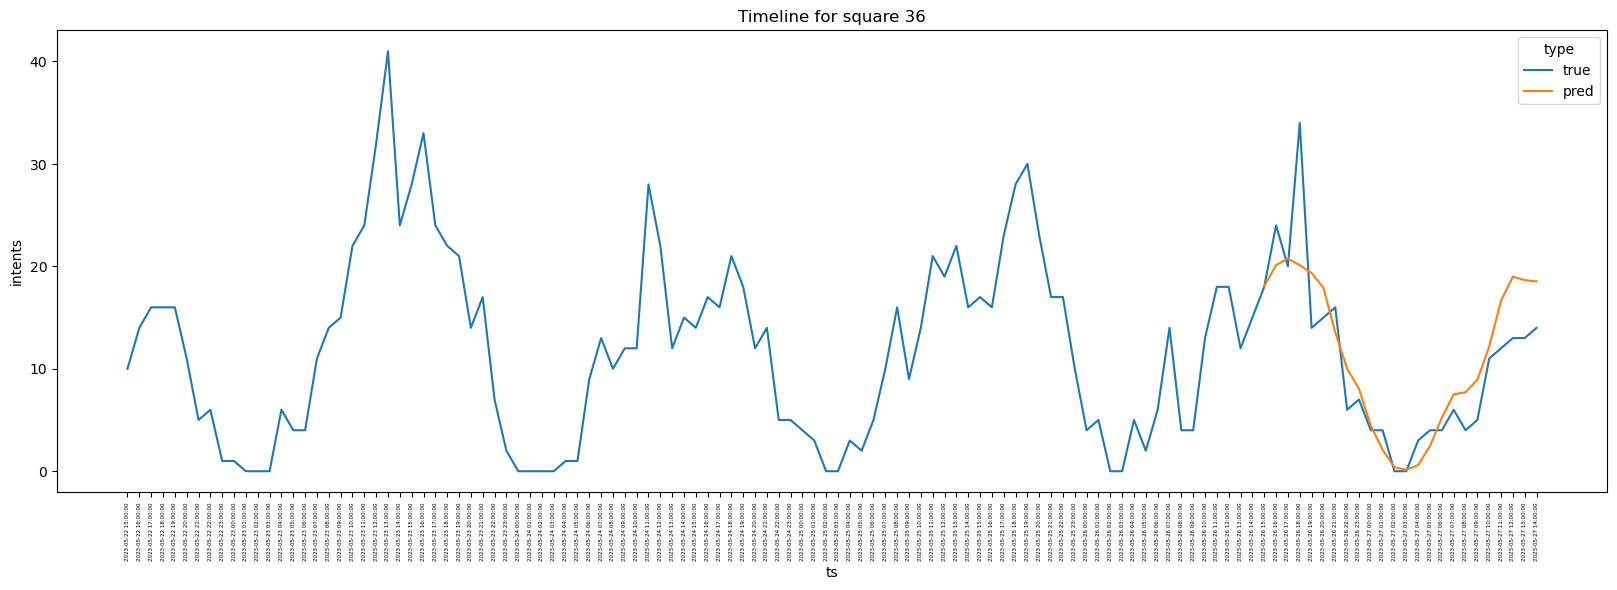

In [29]:
draw_series(test_data, np_preds, tt, ids, 1, 36)  # test_den_data

##### Aggregated

In [30]:
INDEX = 0

f = np_preds[INDEX]
f = np.array([np.round(x).sum() for x in f])

start_tt = time['ts'].values[test_indexes[INDEX]+N_STEPS_PAST:test_indexes[INDEX]+N_STEPS_PAST+HORIZON]

data_agg = data[data['ts'].isin(start_tt)].copy()
data_agg = data_agg[['ts', 'intents']].groupby('ts', as_index=False).sum()
data_agg['type'] = 'true'

#ddata_agg = denoised_df[denoised_df['ts'].isin(start_tt)].copy()
#ddata_agg = ddata_agg[['ts', 'intents']].groupby('ts', as_index=False).sum()
#ddata_agg['type'] = 'denoised'

preds_agg = pd.DataFrame({'ts': start_tt, 'intents': f})
preds_agg['type'] = 'pred'

agg = pd.concat([data_agg, preds_agg], ignore_index=True) # ddata_agg

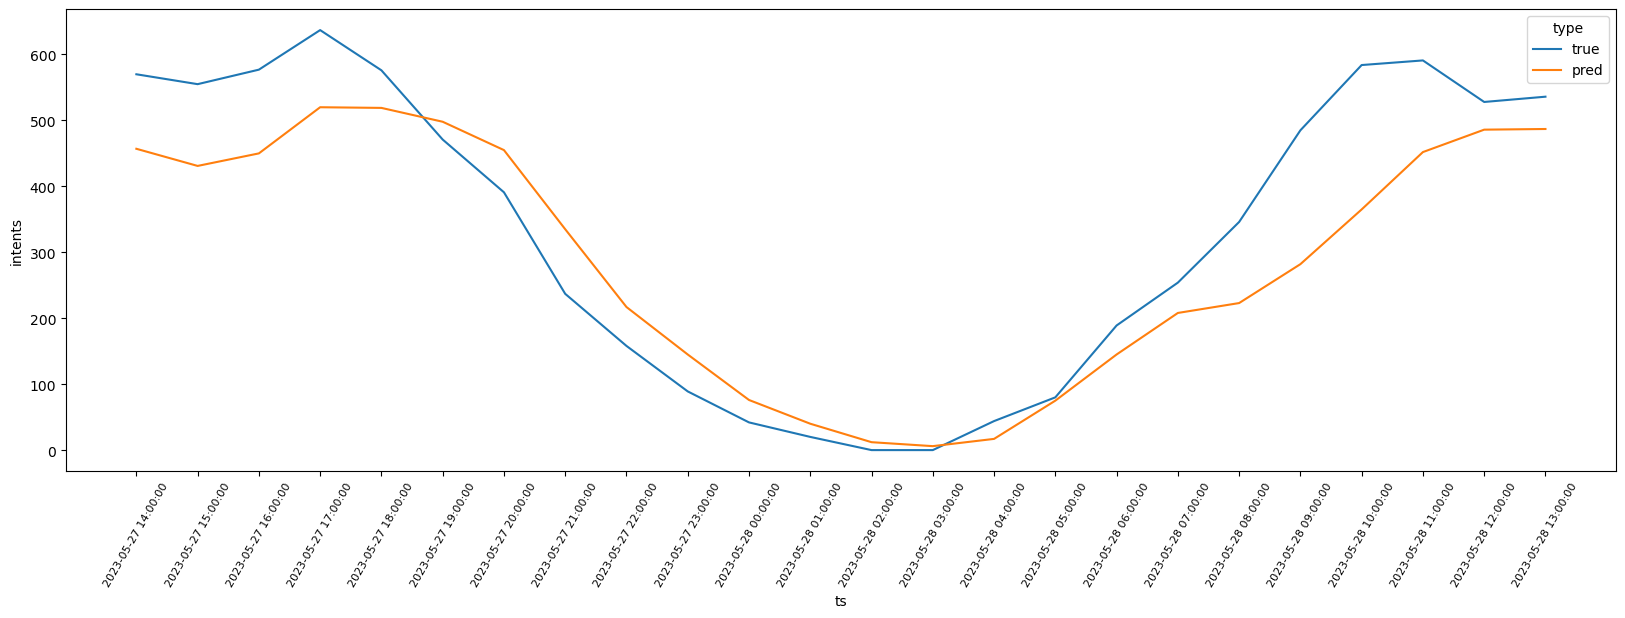

In [31]:
plt.figure(figsize=(20, 6))
sns.lineplot(agg, x='ts', y='intents', hue='type')
plt.xticks(fontsize=8, rotation=60)
plt.show()

### Heatmap Visualization

In [32]:
from ipywidgets import Play, interact

In [33]:
def create_heatmaps(data, np_preds, time, index, ids=ids, squares=squares):
    tt = time['ts'].values[test_indexes[INDEX]+N_STEPS_PAST:test_indexes[INDEX]+N_STEPS_PAST+HORIZON]
    df_true = data[data['ts'].isin(tt)][['ts', 'square_id', 'intents']].copy()
    df_true['intents'] = df_true['intents'].astype(float)
    forecast = np_preds[INDEX]
    df_list = []
    
    for i, ts in enumerate(tt):
        sub = pd.DataFrame({'square_id': ids.flatten(), 'intents': np.round(forecast[i].flatten())})
        sub['ts'] = ts
        df_list.append(sub)
    
    df_hat = pd.concat(df_list, ignore_index=True)
    
    df_true = df_true.merge(squares, on='square_id', how='left')
    df_hat = df_hat.merge(squares, on='square_id', how='left')
    
    df_true = gpd.GeoDataFrame(df_true, geometry=df_true.geometry, crs=4326)
    df_hat = gpd.GeoDataFrame(df_hat, geometry=df_hat.geometry, crs=4326)
    
    return df_true, df_hat


def draw_heatmap(true, pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    ax0 = true.plot(column='intents', legend=True, cmap='OrRd', vmin=0, vmax=100, ax=axes[0])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title('True Heatmap')
    
    ax1 = pred.plot(column='intents', legend=True, cmap='OrRd', vmin=0, vmax=100, ax=axes[1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Predicted Heatmap')
    
    plt.show()

2023-05-28 00:00:00


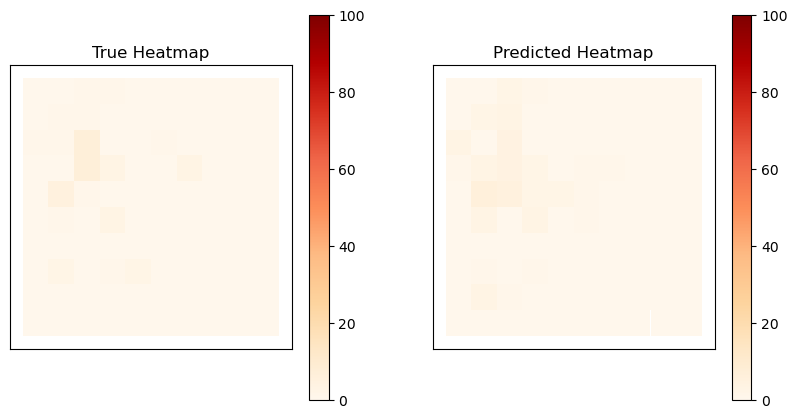

interactive(children=(Play(value=0, description='ts_index', interval=1000, max=23), Output()), _dom_classes=('…

In [34]:
INDEX = 10

df_true, df_pred = create_heatmaps(data, np_preds, time, index=INDEX)  # denoised_df
timesteps = np.sort(df_true.ts.unique())

play = Play(
    value=0,
    min=0,
    max=len(timesteps)-1,
    step=1,
    interval=1000,
    disabled=False
)


@interact(ts_index=play)
def draw_geo_i(ts_index: int) -> None:
    print(timesteps[ts_index])
    draw_heatmap(df_true[df_true.ts == timesteps[ts_index]], df_pred[df_pred.ts == timesteps[ts_index]])